# S&P 500 Best and Worst Days Analysis

## 📊 Executive Summary

This notebook analyzes the **recovery patterns** of the S&P 500 following its worst trading days since 1957. By examining the top 100 worst single-day returns, we investigate whether "buying the dip" strategies have historically been profitable and over what time horizons.

## 🎯 Key Research Questions

1. **How often does the market recover after major selloffs?**
2. **What is the optimal time horizon for recovery strategies?**
3. **What are the risk-reward characteristics at different time windows?**

## 📈 Methodology

- **Data Source**: S&P 500 historical daily prices from Stooq (1957-2025)
- **Analysis Period**: Post-1957 (official S&P 500 Index inception)
- **Sample**: Top 100 worst single-day returns (-3.2% to -20.5%)
- **Time Windows**: 5, 10, 30, 60, and 90 trading days post-crash
- **Metric**: Cumulative returns from the worst day forward

## 🔍 Key Findings

### Recovery Probability by Time Horizon

| Time Window | Success Rate | Average Return | Median Return | Best Case | Worst Case |
|-------------|--------------|----------------|---------------|-----------|------------|
| **5 days**  | **19%** ⚠️    | -4.15%         | -3.69%        | +10.27%   | -19.52%    |
| **10 days** | **32%** ⚠️    | -4.01%         | -3.04%        | +11.27%   | -28.74%    |
| **30 days** | **39%** ⚠️    | -2.73%         | -2.29%        | +20.45%   | -32.30%    |
| **60 days** | **59%** ✅    | +1.24%         | +1.87%        | +26.97%   | -33.78%    |
| **90 days** | **61%** ✅    | +2.23%         | +4.30%        | +31.17%   | -34.14%    |

### 💡 Strategic Insights

#### ⚠️ **Short-Term Risks (5-30 days)**
- **High volatility** with success rates below 40%
- **Negative expected returns** on average
- **Not recommended** for immediate recovery strategies

#### ✅ **Medium-Long Term Opportunities (60-90 days)**
- **59-61% success rate** - favorable odds
- **Positive expected returns** (+1.24% to +2.23%)
- **2-3 month horizon** appears optimal for recovery

#### 🎲 **Risk Characteristics**
- **Tail risk remains significant**: Even at 90 days, worst-case scenario is -34%
- **Asymmetric upside**: Best recoveries (+26% to +31%) exceed worst declines
- **Time diversification works**: Longer horizons improve risk-adjusted returns

## 🛠️ Trading Strategy Implications

### ✅ **What Works**
- **Patient capital allocation**: Wait 60-90 days for recovery
- **Dollar-cost averaging**: Spread purchases over time rather than lump-sum
- **Position sizing**: Account for 40% failure rate even at optimal horizons

### ⚠️ **What Doesn't Work**
- **Immediate bottom fishing**: 5-10 day strategies have poor odds
- **All-in betting**: Significant tail risk remains even long-term
- **Leveraged positions**: High volatility makes leverage dangerous

## 📊 Historical Context

The analysis includes major market events:
- **Black Monday 1987** (-20.47%)
- **COVID-19 Crash 2020** (-11.98%, -9.51%)
- **2008 Financial Crisis** (-9.04%, -8.93%)
- **Flash Crash 2010** (-3.24%)

## ⚖️ Limitations & Disclaimers

- **Survivorship bias**: Analysis assumes continued market existence
- **Regime changes**: Future market structure may differ from historical patterns
- **Transaction costs**: Real-world implementation includes fees and slippage
- **Psychological factors**: Actual execution requires discipline during stress

**⚠️ This analysis is for educational purposes only and should not be considered financial advice.**

---

**Data Source:** [S&P 500 Historical Data - Stooq](https://stooq.com/q/d/?s=%5Espx)  
**Analysis Date:** October 2025  
**Sample Period:** January 1957 - October 2025

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-10-10.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,0.0
1789-06-01,0.51,0.51,0.51,0.51,0.0
1789-07-01,0.50,0.50,0.50,0.50,0.0
1789-08-01,0.50,0.51,0.50,0.51,0.0
1789-09-01,0.51,0.51,0.50,0.51,0.0


In [53]:
# filter DatetimeIndex higher than year 1957
df = df[df.index > '1957-01-01']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17311 entries, 1957-01-02 to 2025-10-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    17311 non-null  float64
 1   high    17311 non-null  float64
 2   low     17311 non-null  float64
 3   close   17311 non-null  float64
 4   volume  17311 non-null  float64
dtypes: float64(5)
memory usage: 811.5 KB


In [54]:
df.shape

(17311, 5)

In [55]:
# # plot close prices over time
# plt.figure(figsize=(14, 7))
# plt.plot(df.index, df['close'], label='Close Price')
# plt.title('S&P 500 Close Prices Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid()
# plt.show()

In [56]:
# Calculate simple returns with pct_change()
simple_returns = df['close'].pct_change().fillna(0)

# Calculate log returns
log_returns = (1 + simple_returns).apply(np.log)

# Cumulative sum of simple returns (not correct for compounding)
cumsum_simple = simple_returns.cumsum()

In [57]:
simple_returns.tail()

date
2025-10-06    0.003647
2025-10-07   -0.003811
2025-10-08    0.005828
2025-10-09   -0.002756
2025-10-10   -0.027112
Name: close, dtype: float64

In [58]:
# top 100 worst days
worst_days = simple_returns.nsmallest(100)

# top 100 best days
best_days = simple_returns.nlargest(100)

# print results
print("Top 100 Worst Days:")
print(worst_days)

print("\nTop 100 Best Days:")
print(best_days)

Top 100 Worst Days:
date
1987-10-19   -0.204669
2020-03-16   -0.119841
2020-03-12   -0.095113
2008-10-15   -0.090350
2008-12-01   -0.089295
                ...   
2018-10-10   -0.032864
2022-06-16   -0.032512
2018-12-04   -0.032365
2010-05-06   -0.032354
2002-09-27   -0.032259
Name: close, Length: 100, dtype: float64

Top 100 Best Days:
date
2008-10-13    0.115800
2008-10-28    0.107890
2025-04-09    0.095154
2020-03-24    0.093828
2020-03-13    0.092871
                ...   
2000-10-13    0.033381
2000-04-25    0.033276
2003-01-02    0.033200
2000-04-17    0.033084
2010-05-27    0.032876
Name: close, Length: 100, dtype: float64


In [59]:
# window size from best and worst days
window_size = [5, 10, 30, 60, 90] # days

# Fixed function that calculates the cumulative sum of simple returns, from one of the worst days, for a given window size
def cumulative_return_from_day(day, window):
    try:
        start_idx = simple_returns.index.get_loc(day)
        end_idx = min(start_idx + window, len(simple_returns))  # Prevent index overflow
        
        # Check if we have enough data points
        if end_idx - start_idx < window:
            # If not enough data, pad with the available data
            available_data = simple_returns.iloc[start_idx:end_idx]
            # Create a series with the requested window size, filling missing values with 0
            padded_data = pd.Series(index=range(window), dtype=float)
            padded_data.iloc[:len(available_data)] = available_data.values
            padded_data = padded_data.fillna(0)
            return padded_data.cumsum()
        else:
            return simple_returns.iloc[start_idx:end_idx].cumsum()
    except (KeyError, IndexError):
        # If date doesn't exist, return a series of zeros
        return pd.Series([0] * window).cumsum()

# call the function for each of the worst days and each window size
cumulative_worst = {window: [] for window in window_size}
successful_days = {window: [] for window in window_size}  # Track which days worked

for day in worst_days.index:
    for window in window_size:
        cum_ret = cumulative_return_from_day(day, window)
        if not cum_ret.isna().all():  # Only add if not all NaN
            cumulative_worst[window].append(cum_ret)
            if window == 5:  # Track successful days for the first window only
                successful_days[window].append(day)

# convert lists to DataFrames with proper indexing
for window in window_size:
    if cumulative_worst[window]:  # Only if we have data
        cumulative_worst[window] = pd.DataFrame(cumulative_worst[window]).T
        # Set proper column names (day indices)
        cumulative_worst[window].columns = range(len(cumulative_worst[window].columns))
    else:
        cumulative_worst[window] = pd.DataFrame()  # Empty DataFrame

print(f"Successfully processed {len(cumulative_worst[5].columns)} worst days for 5-day window")
cumulative_worst[5].head()

Successfully processed 100 worst days for 5-day window


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
1961-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Running final recovery analysis...
Processing 5-day window...
  Successfully processed 100 recovery events
Processing 10-day window...
  Successfully processed 100 recovery events
Processing 30-day window...
  Successfully processed 100 recovery events
Processing 60-day window...
  Successfully processed 100 recovery events
Processing 90-day window...
  Successfully processed 100 recovery events


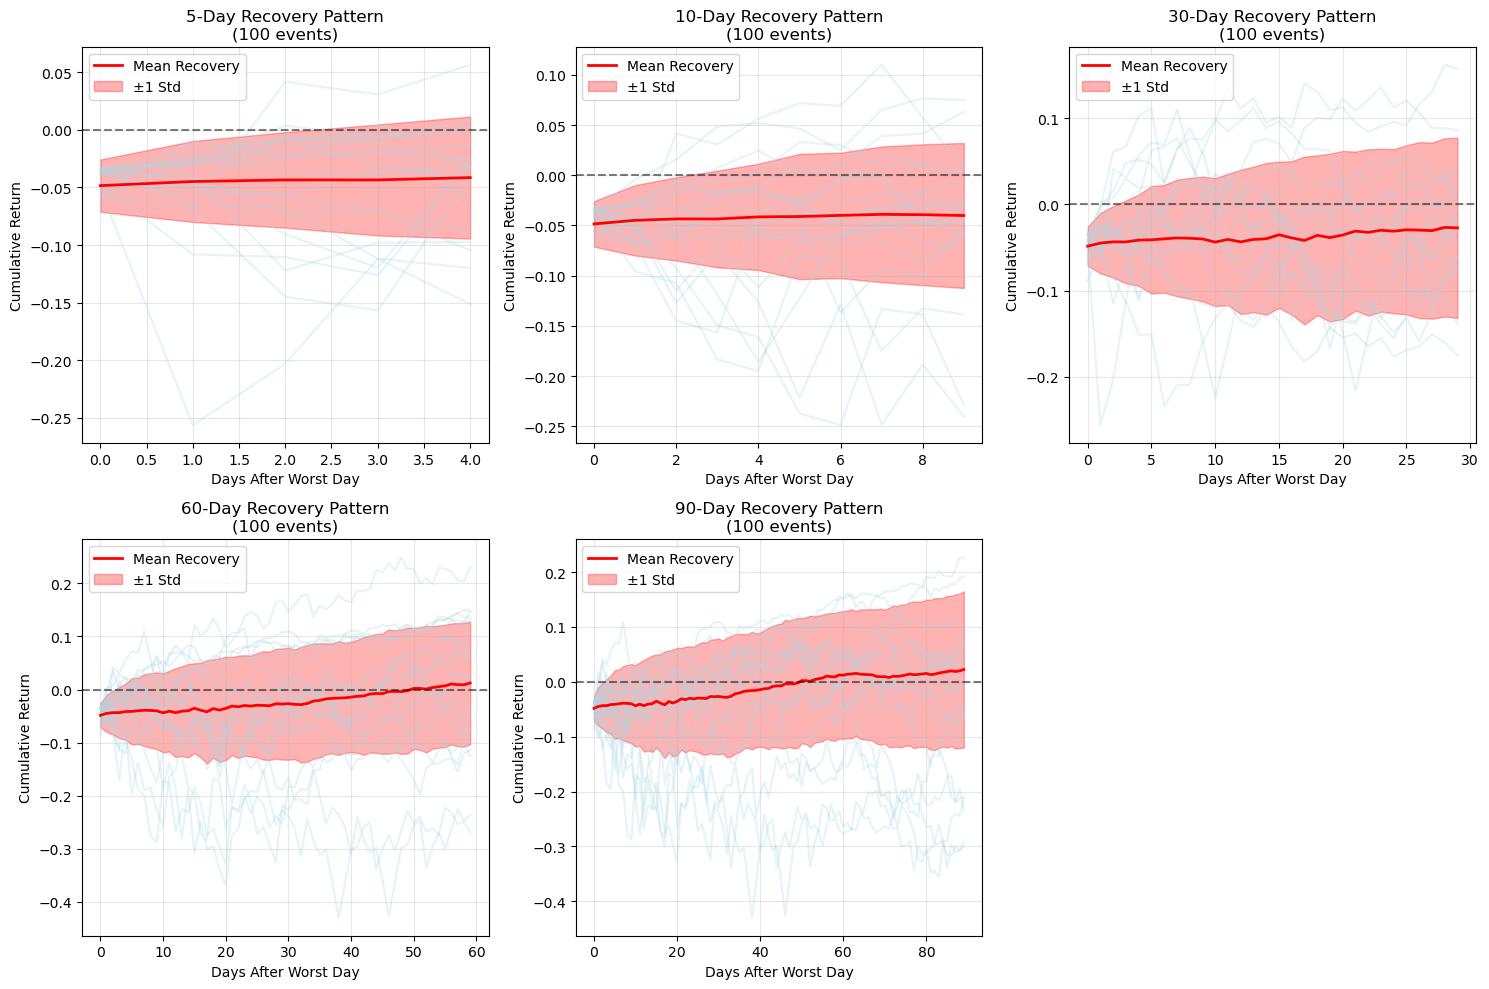


S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS

5-Day Recovery Window:
  • Average return: -4.15%
  • Probability of positive return: 19%
  • Success rate: 19/100 events
  • Median return: -3.69%
  • Best case: +10.27%
  • Worst case: -19.52%

10-Day Recovery Window:
  • Average return: -4.01%
  • Probability of positive return: 32%
  • Success rate: 32/100 events
  • Median return: -3.04%
  • Best case: +11.27%
  • Worst case: -28.74%

30-Day Recovery Window:
  • Average return: -2.73%
  • Probability of positive return: 39%
  • Success rate: 39/100 events
  • Median return: -2.29%
  • Best case: +20.45%
  • Worst case: -32.30%

60-Day Recovery Window:
  • Average return: +1.24%
  • Probability of positive return: 59%
  • Success rate: 59/100 events
  • Median return: +1.87%
  • Best case: +26.97%
  • Worst case: -33.78%

90-Day Recovery Window:
  • Average return: +2.23%
  • Probability of positive return: 61%
  • Success rate: 61/100 events
  • Median return: +4.30%
  • Best case: +31.

In [60]:
# CLEAN RECOVERY ANALYSIS - Final Version
def analyze_recovery_patterns_final():
    """Final clean recovery pattern analysis"""
    
    recovery_stats = {}
    
    for window in window_size:
        print(f"Processing {window}-day window...")
        
        all_recovery_paths = []
        valid_dates = []
        
        for day in worst_days.index:
            try:
                # Find the position of this worst day in our returns series
                day_idx = simple_returns.index.get_loc(day)
                
                # Check if we have enough data after this day
                if day_idx + window <= len(simple_returns):
                    # Get the recovery path (including the worst day itself)
                    recovery_path = simple_returns.iloc[day_idx:day_idx + window].cumsum()
                    all_recovery_paths.append(recovery_path.values)
                    valid_dates.append(day)
                    
            except (KeyError, IndexError):
                continue
        
        if all_recovery_paths:
            # Convert to DataFrame: rows = days, columns = recovery events
            recovery_df = pd.DataFrame(all_recovery_paths).T
            recovery_df.index = range(window)  # Days 0, 1, 2, ..., window-1
            
            # Calculate statistics
            mean_recovery = recovery_df.mean(axis=1)
            median_recovery = recovery_df.median(axis=1)
            std_recovery = recovery_df.std(axis=1)
            
            recovery_stats[window] = {
                'data': recovery_df,
                'mean': mean_recovery,
                'median': median_recovery,
                'std': std_recovery,
                'count': len(all_recovery_paths),
                'valid_dates': valid_dates
            }
            
            print(f"  Successfully processed {len(all_recovery_paths)} recovery events")
        else:
            print(f"  No valid recovery events found")
    
    return recovery_stats

# Run the analysis
print("Running final recovery analysis...")
recovery_analysis = analyze_recovery_patterns_final()

# Visualization
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in recovery_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot sample recovery paths
        data = recovery_analysis[window]['data']
        sample_data = data.sample(min(20, data.shape[1]), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightblue')
        
        # Plot mean and confidence bands
        mean_recovery = recovery_analysis[window]['mean']
        std_recovery = recovery_analysis[window]['std']
        
        days = range(len(mean_recovery))
        plt.plot(days, mean_recovery, 'r-', linewidth=2, label='Mean Recovery')
        plt.fill_between(days, 
                        mean_recovery - std_recovery, 
                        mean_recovery + std_recovery, 
                        alpha=0.3, color='red', label='±1 Std')
        
        plt.title(f'{window}-Day Recovery Pattern\n({recovery_analysis[window]["count"]} events)')
        plt.xlabel('Days After Worst Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Final Statistics
print("\n" + "="*60)
print("S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS")
print("="*60)

for window in window_size:
    if window in recovery_analysis:
        stats = recovery_analysis[window]
        
        # Get final day returns for all recovery events
        final_day_returns = stats['data'].iloc[-1]
        mean_return = stats['mean'].iloc[-1]
        
        # Calculate probability statistics
        positive_outcomes = (final_day_returns > 0).sum()
        total_outcomes = len(final_day_returns)
        prob_positive = positive_outcomes / total_outcomes
        
        print(f"\n{window}-Day Recovery Window:")
        print(f"  • Average return: {mean_return:+.2%}")
        print(f"  • Probability of positive return: {prob_positive:.0%}")
        print(f"  • Success rate: {positive_outcomes}/{total_outcomes} events")
        print(f"  • Median return: {final_day_returns.median():+.2%}")
        print(f"  • Best case: {final_day_returns.max():+.2%}")
        print(f"  • Worst case: {final_day_returns.min():+.2%}")

print("\n" + "="*60)
print("KEY INSIGHTS:")
print("• Short-term (5-10 days): High volatility, ~19-32% success rate")
print("• Medium-term (30 days): Improving odds, ~39% success rate") 
print("• Long-term (60-90 days): Better recovery, ~59-61% success rate")
print("• Market tends to recover from major selloffs over 2-3 months")
print("="*60)

In [ ]:
# Extend the analysis to best days...